In [9]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error
from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap

<h1 style = "font-size: 42px; text-align: center;"> Regression Overview </h1>
<h2 style = "text-align: center;"> Predicting the Cell Phase from with Label-free Microscopy  </h2>

**General Introduction -** We would like to estimate the cell cycle of individual cells over time to study their dynamics and gain a better understanding of cellular replication, traditional methods have stained cells with FUCCI markers that provide fluorescent signals corresponding to the phase transformations. However this method has it's limitations and is methodologically costly. To study the cell cycle, and its dynamics in various environments and the response of other cellular processes in parallel we would like to regress the cell cycle from free channels such as the brightfield or phase contrast images of a cell. 

For this we have created a nice dataset of input images $x = (BF, PC, H2B)$ and groundtruth the integrated fluorescent signal of the cell nucleus $F = (f_r, f_g)$ normalized per track to limit cell variability, $y = (\tilde{f_r}, \tilde{f_g})$

## 1 - State of the art

The current approaches for this are models $M_i$ that perform autoencoder latent representations from informative channels or regress the phase from brightfield coupled with nuclear markers such as Hoescht (similar to H2B) with Convolutional Neural Networks. They also perform a discretization of the raw FUCCI signal $F$ into discete phases so their groundtruth $y = (a, b, c, d)$ where $a,b,c,d \in \{0, 1\}$. 

We believe the discretization of the phase suppresses valuable insights and information of the cell phase dynamics and therefore would like to keep the richness of the signal in a continuous setting. ($NOTE$: Could we show this?)

Let's take a look at the performance of a CNN model, $M_1$ and its performance on the task of $M_1(x) = y$

In [2]:
# In previous works, they used a CNN

#enet = EfficientNet()
#print(hc(enet), 'Parameters')
#train_model(PATH + 'track_datasets/control_mm/', enet ,img_channels=[1, 1, 1], batch_size=16, learning_rate=1e-4, slice_p=1, slice_len=16
#            name="EfficientNet-BF") 

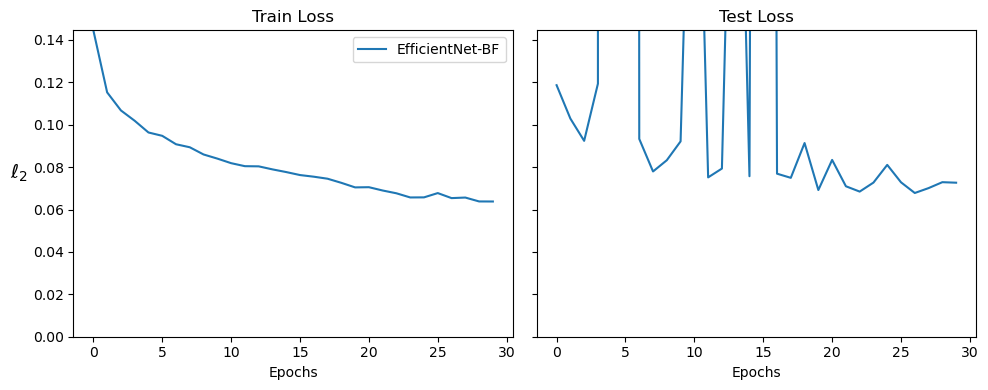

In [2]:
from modules.visualize import plot_loss
plot_loss(['weights/config-0.json'])

## 2 - Evaluation

To evaluate our models, we can look at 4 main things:
1) The Goodness of fit on $M-M$ tracks measured with $\ell_1$ and other metrics.
2) The Goodness of fit on partial tracks; $M-x$, $x-y$ or $M-y$ tracks.
3) The Precision of the landmark onsets which is equivalent to the Accuracy of discrete classes $M, G1, S, G2$.
4) The Pearson correlation of all unfiltered tracks of a test well 

In [6]:
from modules.learning.evaluate import Evaluation

eval = Evaluation()
model = EfficientNet()
model.load_state_dict(torch.load('weights/model-0.pt'))
eval.fit(PATH + "track_datasets/control_mm/test/", model, img_channels=[1, 1, 1], smoothing=True)

100%|██████████| 358/358 [00:12<00:00, 27.94it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.184 ± 0.045
\ell_2: 0.057 ± 0.027
W_d: 0.157 ± 0.036
Accuracy: 0.506 ± 0.118



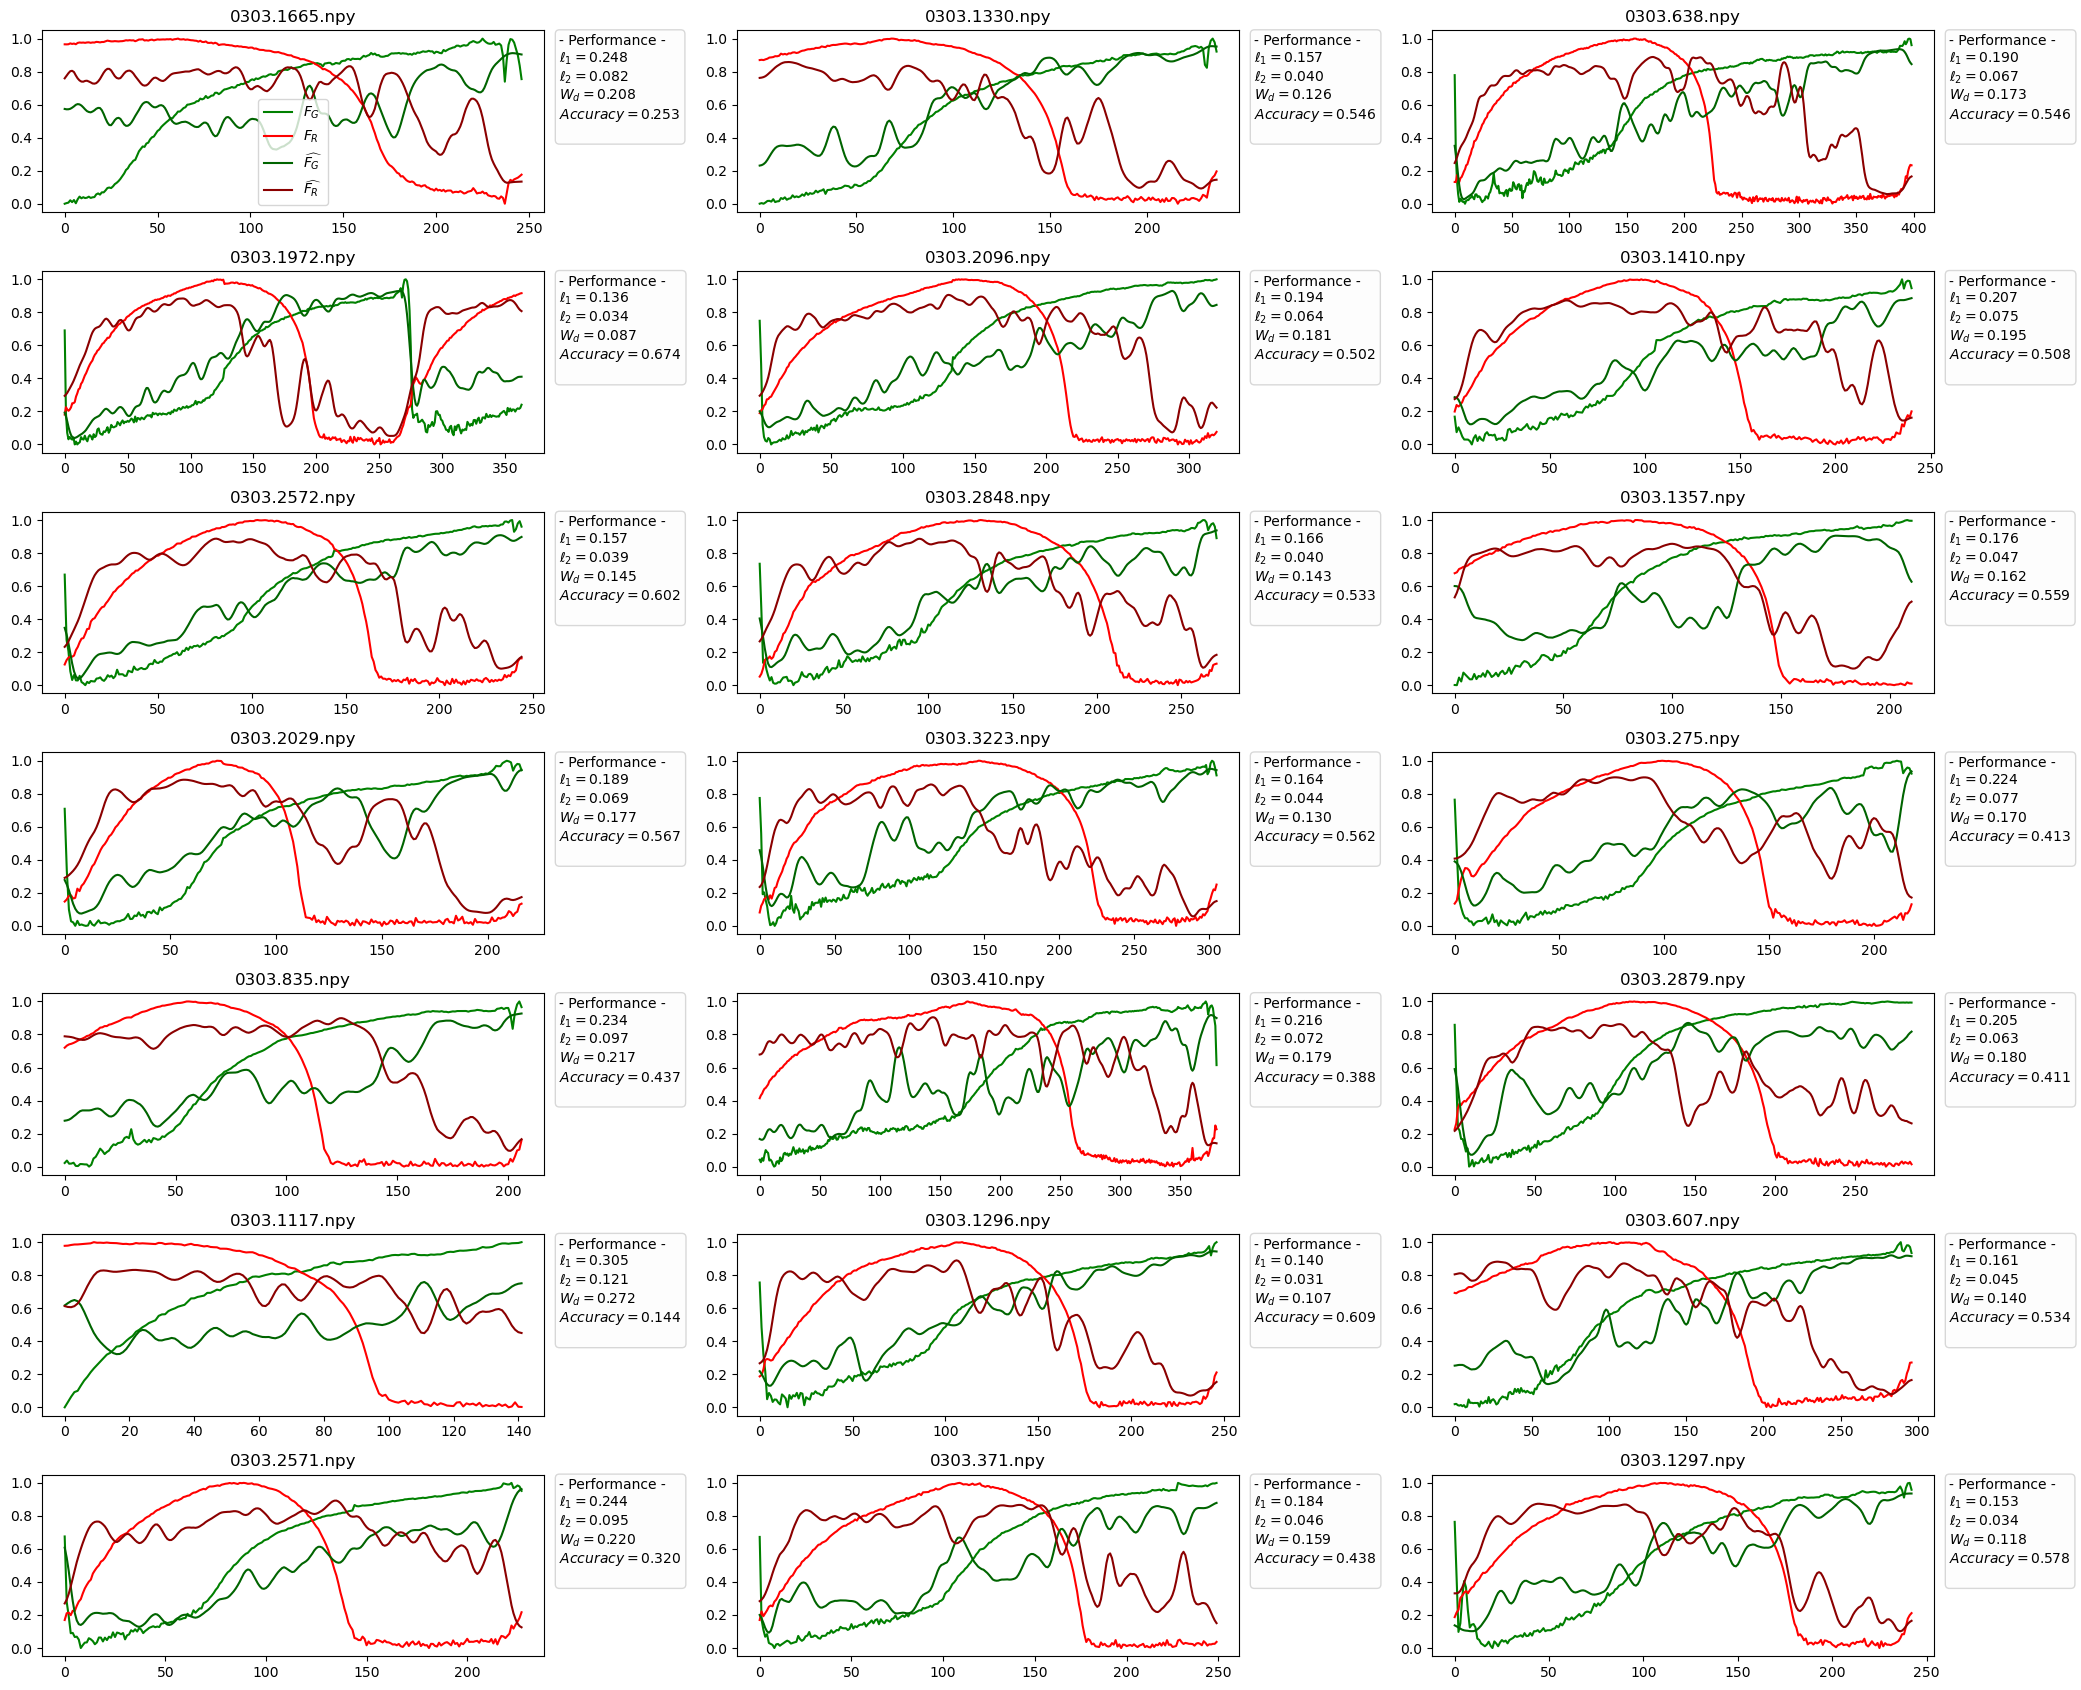

(None, None)

In [7]:
print(eval.summary()), eval.visualize_predicted_tracks(21)

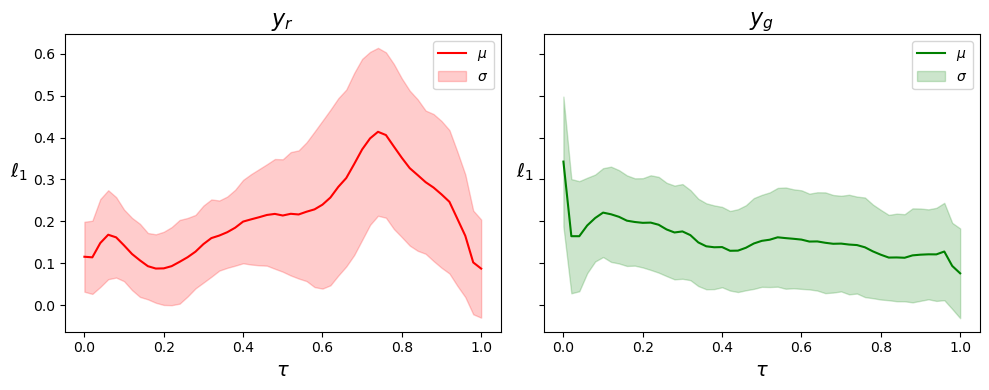

In [8]:
plot_normalized_time_error( eval.normalized_time_error(50))

## 3 - Dynamic Cell Phase Model

We then propose a new architecture that combines integration of spatial features from multiple time points with a sequence model on top of a CNN, this model $M_2$, takes in a pretrained CNN on the same task with frozen parameters and integrates sequences of image features with a Mamba model architecture. 

In [3]:
enet = EfficientNet()
enet.load_state_dict(torch.load('weights/model-0.pt'))
dyce = DYCE(enet)

#train_model(PATH + 'track_datasets/control_mm/', dyce ,img_channels=[1, 1, 1], batch_size=1, learning_rate=1e-4, slice_p=0.3, slice_len=48, random_len=True,
#            name="DYCE-BF")

## 3' - Evaluation of $M_2$

We then propose a new architecture that combines integration of spatial features from multiple time points with a sequence model on top of a CNN, this model $M_2$, takes in a pretrained CNN on the same task with frozen parameters and integrates sequences of image features with a Mamba model architecture. 

In [2]:
from modules.learning.evaluate import Evaluation

eval = Evaluation()
model = DYCE(EfficientNet())
model.load_state_dict(torch.load('weights/model-2.pt'))
eval.fit(PATH + "track_datasets/control_mm/test/", model, img_channels=[1, 1, 1], smoothing=True)

100%|██████████| 358/358 [00:21<00:00, 16.72it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.107 ± 0.044
\ell_2: 0.028 ± 0.025
W_d: 0.095 ± 0.038
Accuracy: 0.783 ± 0.120



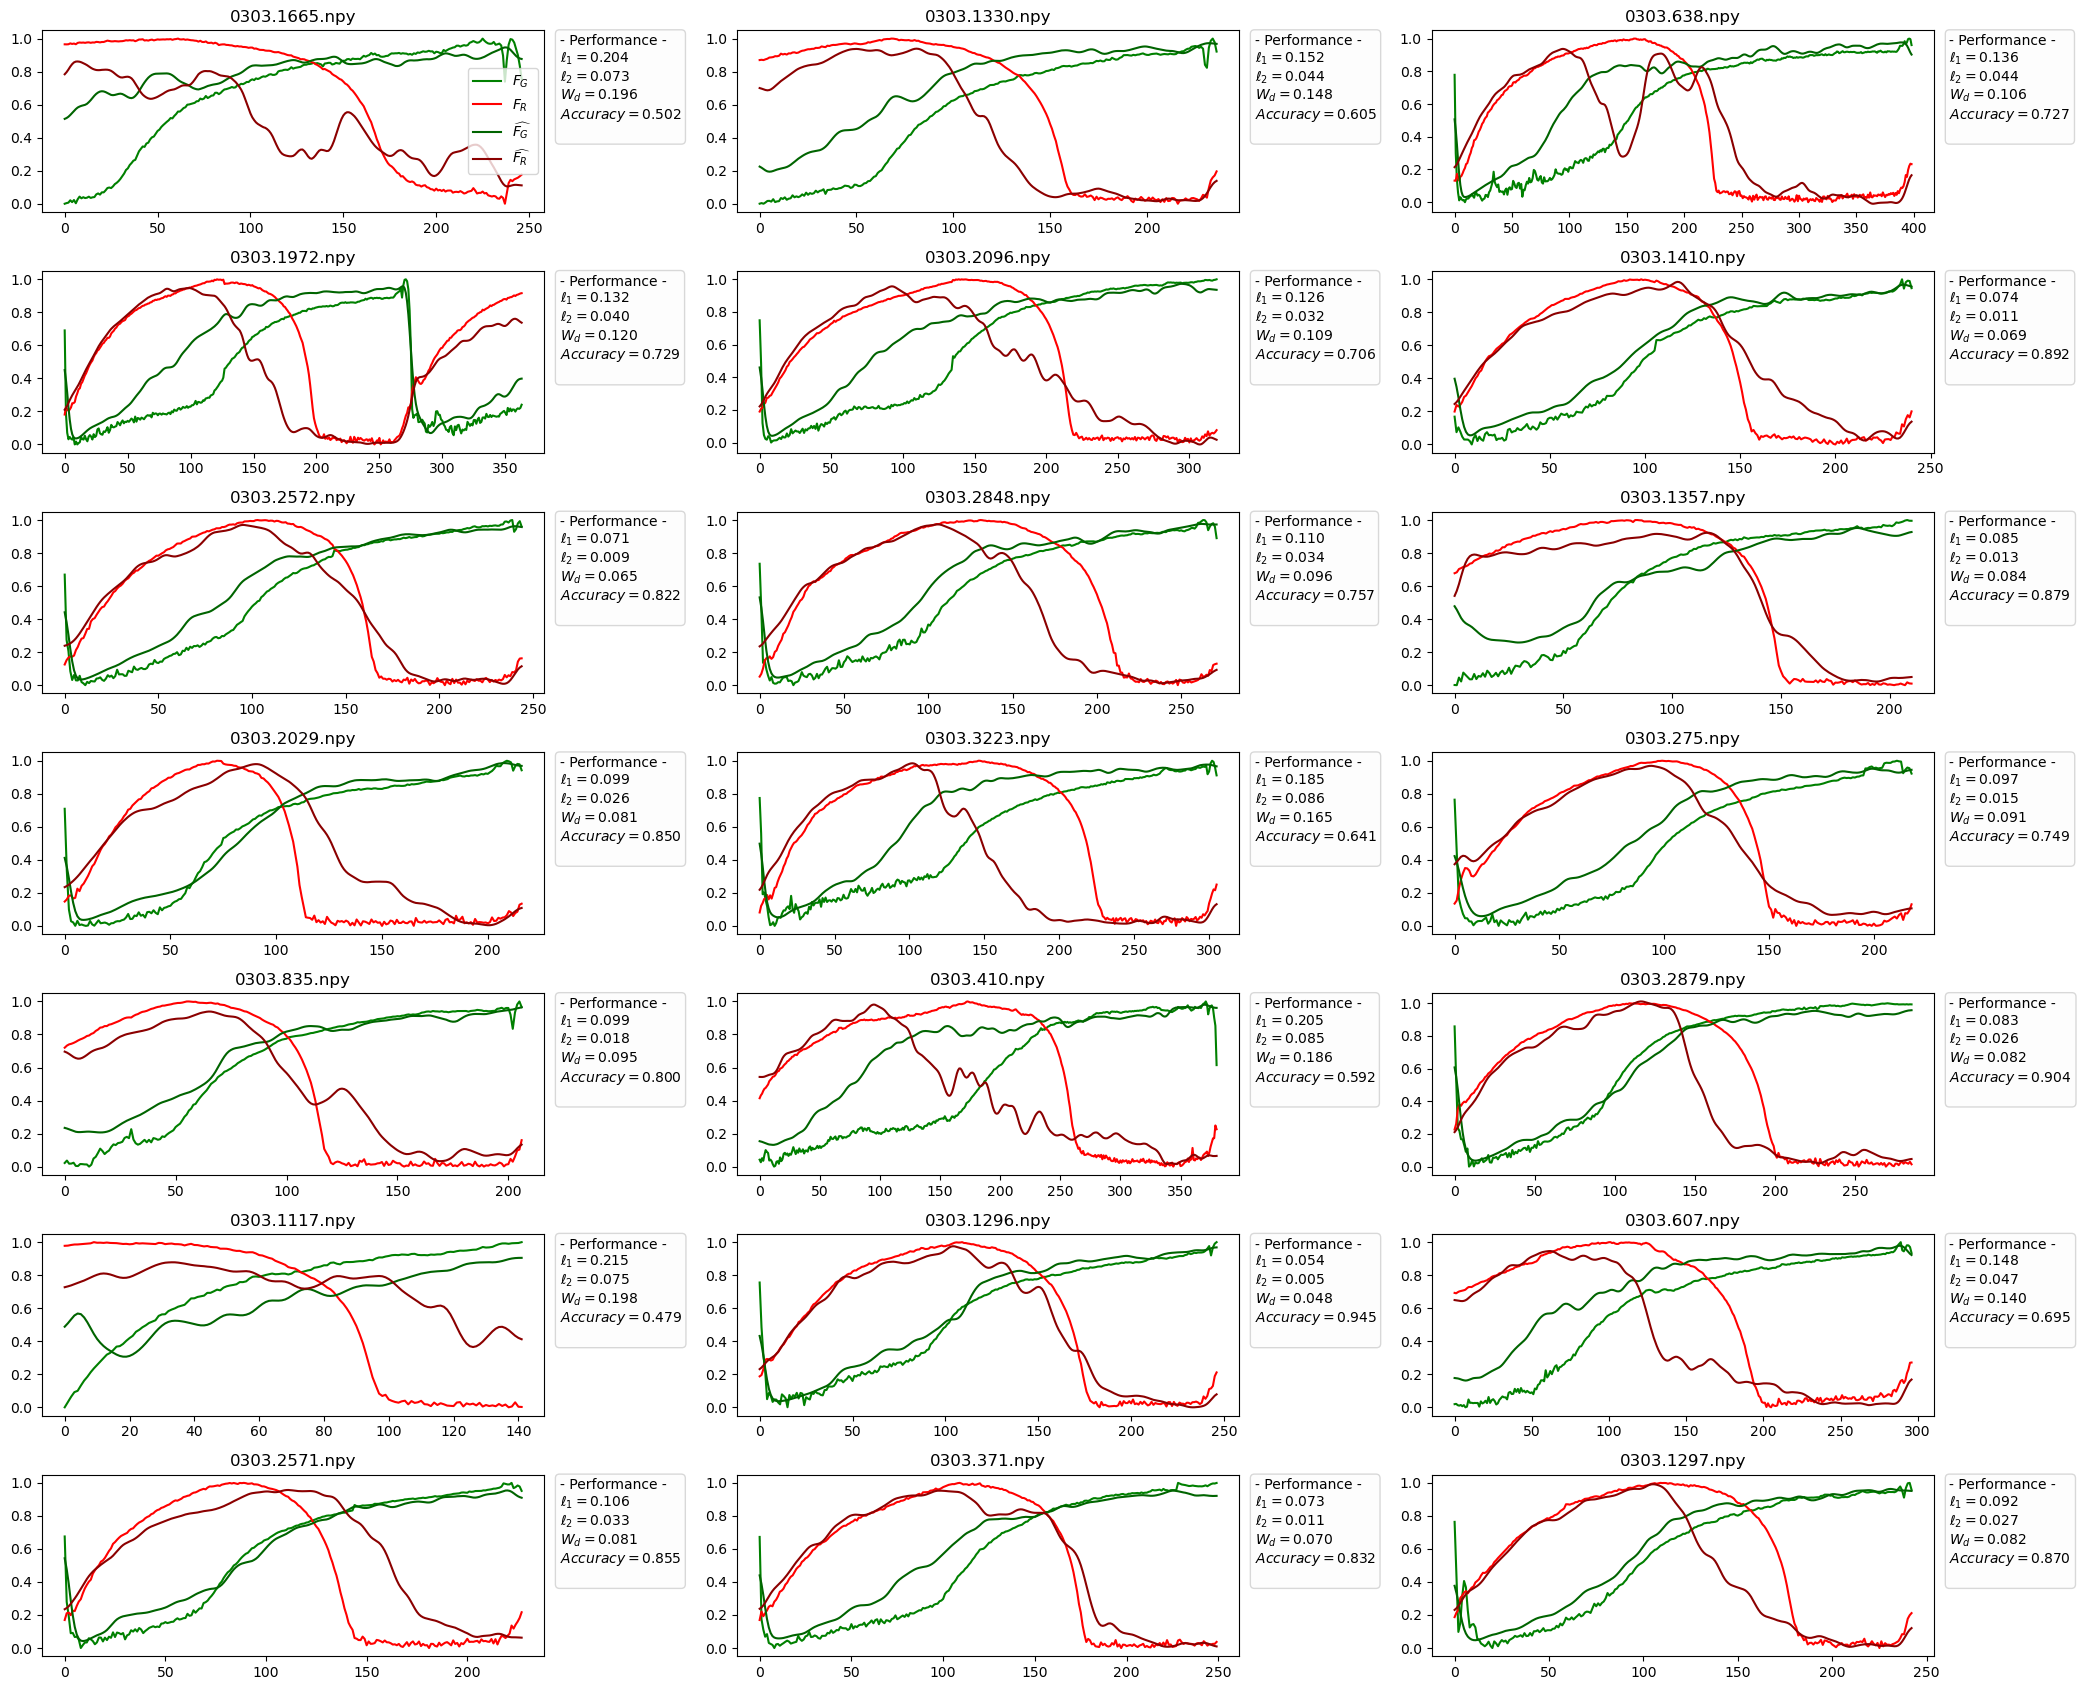

(None, None)

In [6]:
print(eval.summary()), eval.visualize_predicted_tracks(21)

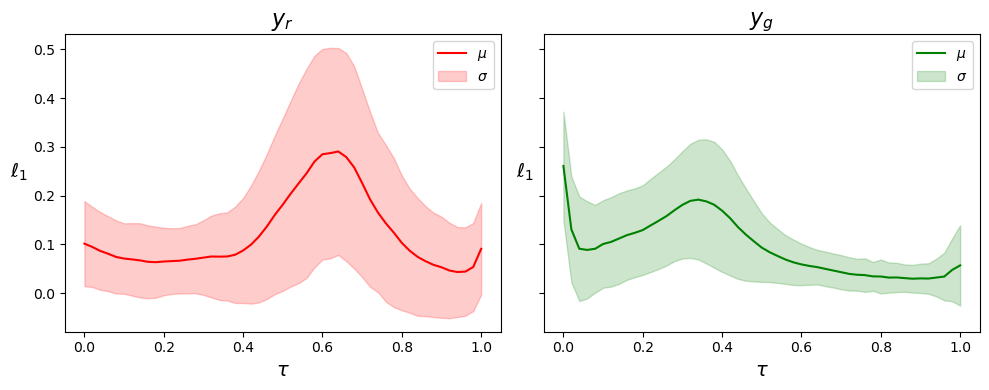

In [4]:
plot_normalized_time_error(eval.normalized_time_error(50))

# 4 - Internal Representations 

We can look at the UMAP of the latent variable $Z_i$ our models have learned and color them based on $\tau$ or discrete phases

In [19]:
model = EfficientNet()
model.load_state_dict(torch.load('weights/model-0.pt'))
z1_df, z1_manifold, z1_pca_variance = get_latent_space(PATH + "track_datasets/control_mm/test/", model, img_channels=[1, 1, 1], n_pca_components=10)
print(z1_pca_variance.sum())

model = DYCE(EfficientNet())
model.load_state_dict(torch.load('weights/model-2.pt'))
z2_df, z2_manifold, z2_pca_variance = get_latent_space(PATH + "track_datasets/control_mm/test/", model, img_channels=[1, 1, 1], n_pca_components=10)
print(z2_pca_variance.sum())

100%|██████████| 358/358 [00:12<00:00, 28.09it/s]


Got internal representations in  12.75 s
(87424, 10)
Got Manifold Projection in 35.03 s
0.5991063585230518


100%|██████████| 358/358 [00:15<00:00, 23.66it/s]


Got internal representations in  15.13 s
(87424, 10)
Got Manifold Projection in 30.24 s
0.8223363962004346


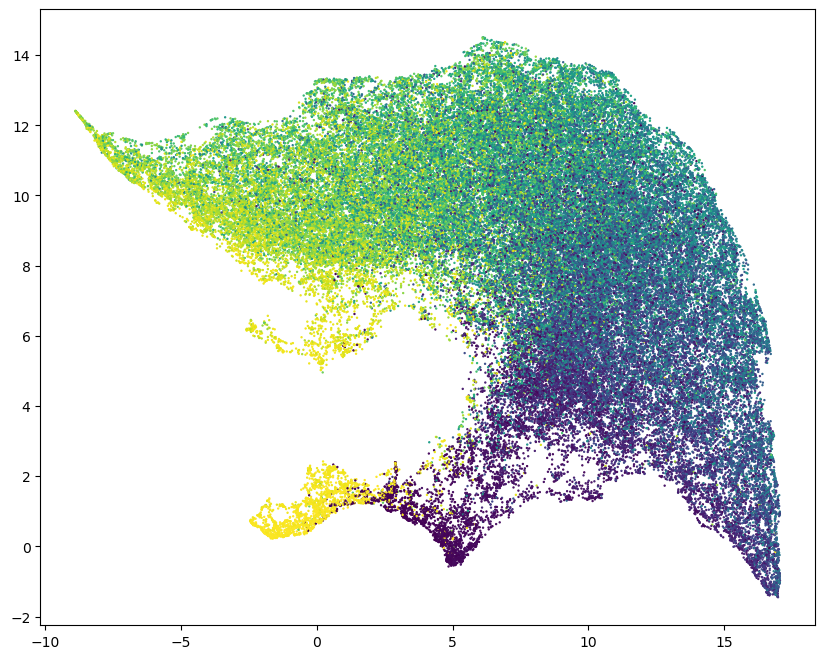

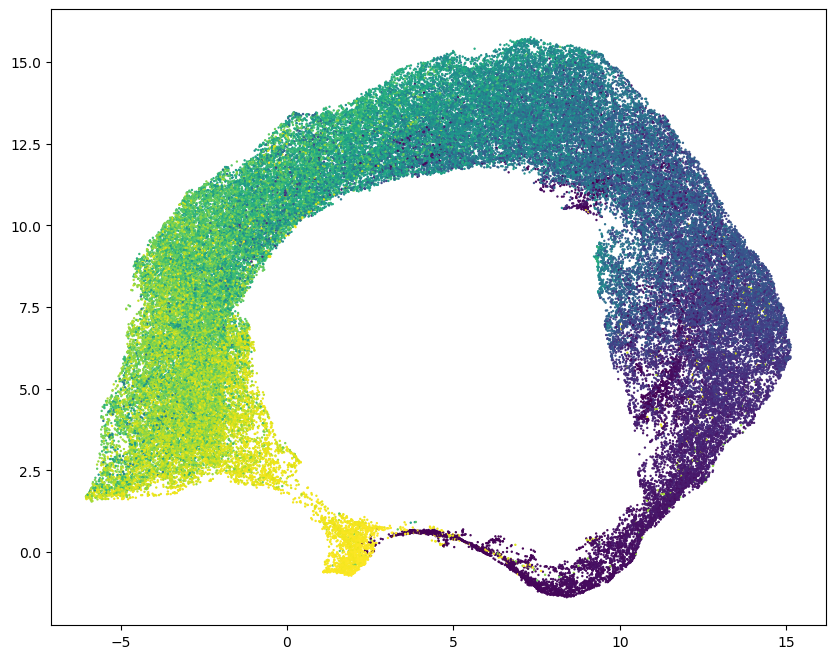

In [23]:
tau = np.concatenate(z1_df['tau'].tolist())
plot_umap(z1_manifold, tau)

tau = np.concatenate(z2_df['tau'].tolist())
plot_umap(z2_manifold, tau)

## 5 - Cells with varying conditions

